## Time to get your hands dirty. SDSS Galaxies vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new in computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?



---



# Classification of Quasars vs Galaxies
## Data Loading

In [8]:
import pandas as pd

data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [9]:
import numpy as np

# Extract data as 1D arrays instead of 2D
u = np.array(data['u'])
g = np.array(data['g'])
r = np.array(data['r'])
i = np.array(data['i'])
z = np.array(data['z'])
y = np.array([1 if d == 'QSO' else 0 for d in data['class']])

# Calculate color differences
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z

# Create feature matrix
X = np.array((u_g, g_r, r_i, i_z))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4, 50000)
Shape of y: (50000,)


## Some quick exploration of the data

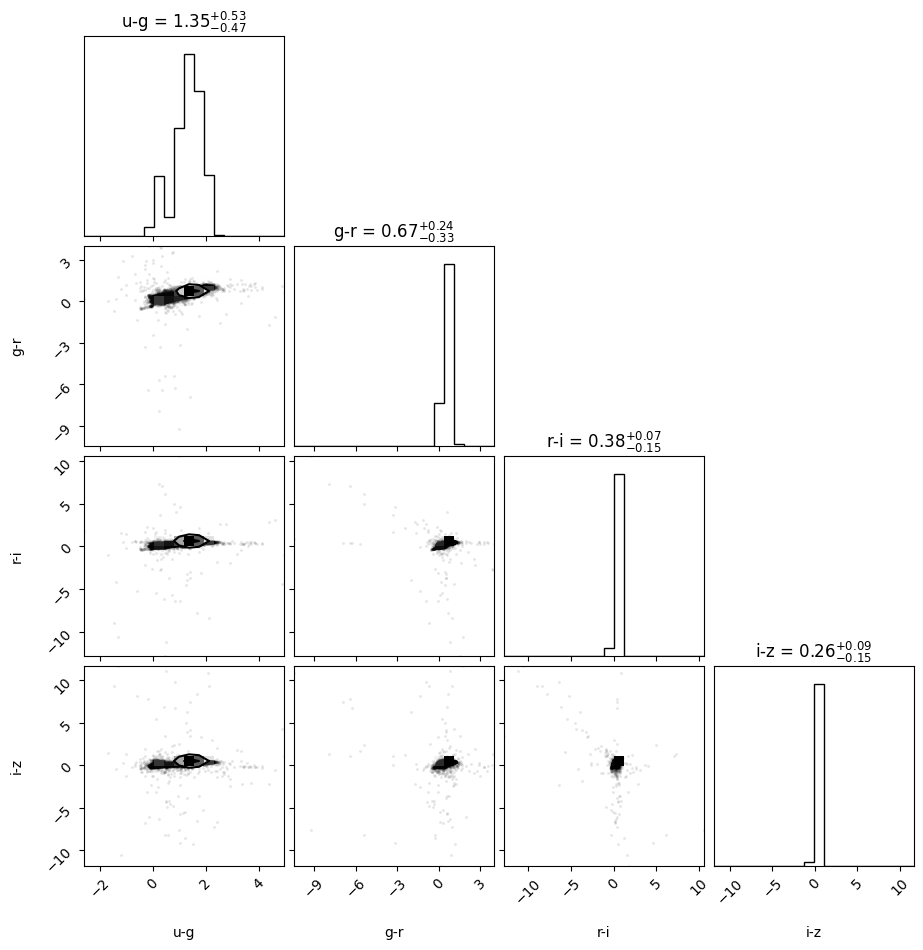

In [10]:
import corner

corner.corner(X.T, labels=['u-g', 'g-r', 'r-i', 'i-z'], show_titles=True);

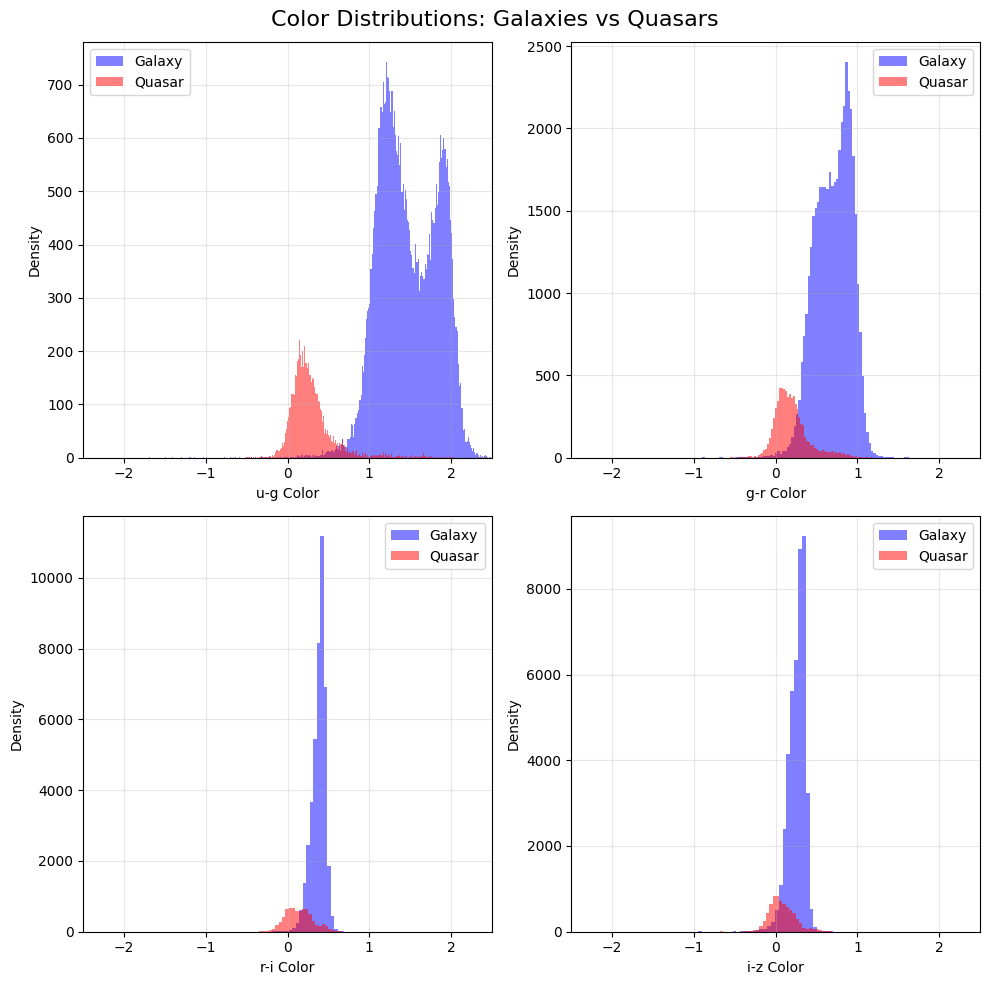

In [11]:
import matplotlib.pyplot as plt

# Filter data for galaxies and quasars
galaxy_mask = (y == 0)
quasar_mask = (y == 1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Color Distributions: Galaxies vs Quasars', fontsize=16)

# Color arrays and labels
labels = ['u-g Color', 'g-r Color', 'r-i Color', 'i-z Color']

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, label in enumerate(labels):
    ax = axes_flat[i]
    color_data = X[i, :]

    # Plot histograms
    ax.hist(color_data[galaxy_mask], bins=int(len(color_data)/100), alpha=0.5, label='Galaxy', color='blue')
    ax.hist(color_data[quasar_mask], bins=int(len(color_data)/100), alpha=0.5, label='Quasar', color='red')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.set_xlim(-2.5, 2.5)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Training and Test sets creation

In [12]:
from sklearn.model_selection import train_test_split    

X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.2)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (40000, 4)
Test set size: (10000, 4)


## Classification with different algorithms

### Gaussian Naive Bayes (GNB)
The idea behind Naive Bayes classification is that we can assume the features to be indipendent, in this way the probability of a certain class can be computed as the product of the probabilities of each feature given that class. This is a strong assumption, but it works quite well in practice.
$$
p(\vec{x}|C_k) = \prod_{i=1}^{N} p(x_i|C_k)
$$
Using the Bayes theorem we can compute the posterior probability of a class given the features:
$$
p(C_k|\vec{x}) = \frac{p(\vec{x}|C_k)p(C_k)}{p(\vec{x})} = \frac{\prod_{i=1}^{N} p(x_i|C_k)p(C_k)}{\sum_{j} \prod_{i=1}^{N} p(x_i|C_j)p(C_j)}
$$
and we can classify a new object by choosing the class with the highest posterior probability:
$$
\hat{C} = \arg\max_{k} p(C_k|\vec{x}) = \arg\max_{k} \frac{\prod_{i=1}^{N} p(x_i|C_k)p(C_k)}{\sum_{j} \prod_{i=1}^{N} p(x_i|C_j)p(C_j)}
$$ 
where $p(C_k)$ is just the frequency of the class $k$ and $p(x|C_k)$ is just the density (probability) of an object with class $k$ having the attributes $x$.

**Observation**: Use the posterior or the logarithm of the posterior is obviously equivalent.

When we have to deal with continuous features we can assume that the features are distributed according to a Gaussian distribution, in this case we have to estimate the mean and the standard deviation of each feature for each class.
$$
p(x_i|C_k) = \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left(-\frac{(x_i - \mu_{ik})^2}{2\sigma_{ik}^2}\right)
$$
So we can compute the logarithm of the posterior probability of a class given the features as:
$$
\log p(C_k|\vec{x}) = \log p(C_k) - \frac{1}{2} \sum_{i=1}^{N} \bigg( \frac{(x_i - \mu_{ik})^2}{\sigma_{ik}^2} + \log 2\pi\sigma_{ik}^2 \bigg)   
$$
So the algorithm find the class that maximizes the above expression.

**Observation**: The constant term $\log 2\pi$ can be ignored since it is the same for all classes, in the same way we have ignored the denominator.

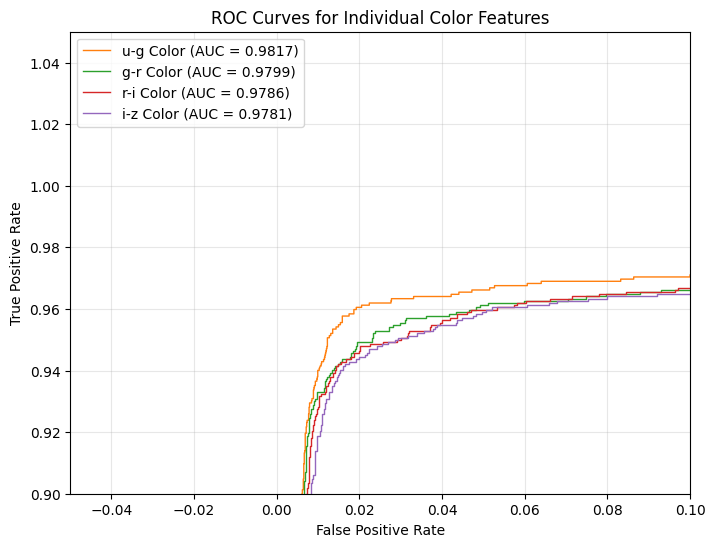

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc

def ROC_plot(classifier):

    plt.figure(figsize=(8, 6))

    plt.plot([0, 1], [0, 1], linestyle='--')

    for i, label in enumerate(labels):
        # Select the first i+1 features for training and testing
        train = X_train[:, :i+1]
        test = X_test[:, :i+1]

        # Fit the model and predict probabilities
        classifier.fit(train, y_train)
        y_pred = classifier.predict_proba(test)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=label+f' (AUC = {roc_auc:.4f})')

    plt.xlim([-0.05, 0.1])
    plt.ylim([0.9, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Individual Color Features')
    plt.legend(loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.show()

gnb = GaussianNB()
ROC_plot(gnb)

To evaluate the performance of the algorithm we have used the **Receiver Operating Characteristic (ROC) curve**, that is a plot of the **True Positive Rate (TPR)** (the statistical power of the model) against the **False Positive Rate (FPR)** (the Type I error) for different threshold values. The Area Under the Curve (AUC) is a measure of the performance of the algorithm, **the higher the AUC the better the performance**.

### Lineae & Quadratic Discriminant Analysis (LDA & QDA)
The Gaussan Naive Bayes classifier assumes that the features are indipendent, this is a strong assumption that is not always true. If we accept that the features have some correlation, and that there is a **covariance matrix**, $\Sigma$, that describes this correlation, the logarithm of the posterior assumes the following form:
$$
\log p(C_k|\vec{x}) = \log p(C_k) - \frac{1}{2} \bigg( (\vec{x} - \vec{\mu}_k)^T \Sigma_k^{-1} (\vec{x} - \vec{\mu}_k) + \log|\Sigma_k| \bigg)
$$

**Observation**: Remember that the pdf of a multivariate Gaussian is:
$$
p(\vec{x}) = \frac{1}{(2\pi)^{N/2} |\vec{\Sigma}|^{1/2}} \exp\bigg(-\frac{1}{2} (\vec{x} - \vec{\mu})^T \vec{\Sigma}^{-1} (\vec{x} - \vec{\mu})\bigg)
$$  

If we expand the therm $(\vec{x} - \vec{\mu}_k)^T \Sigma_k^{-1} (\vec{x} - \vec{\mu}_k)$ we obtain:
$$
(\vec{x} - \vec{\mu}_k)^T \Sigma_k^{-1} (\vec{x} - \vec{\mu}_k) = \vec{x}^T \Sigma_k^{-1} \vec{x} - 2\vec{\mu}_k^T \Sigma_k^{-1} \vec{x} + \vec{\mu}_k^T \Sigma_k^{-1} \vec{\mu}_k
$$
$$
\log p(C_k|\vec{x}) = -\frac{1}{2} \vec{x}^T \Sigma_k^{-1} \vec{x} + \vec{\mu}_k^T \Sigma_k^{-1} \vec{x} - \frac{1}{2} \vec{\mu}_k^T \Sigma_k^{-1} \vec{\mu}_k + \log p(C_k) - \frac{1}{2} \log|\Sigma_k|
$$

we can see how the expression contains a quadratic term in $\vec{x}$, a linear term in $\vec{x}$ and a constant term. If we assume that the covariance matrix is the same for all classes, $\Sigma_k = \Sigma$, the quadratic term cancels out (because it became a constant therm) and we obtain a linear expression in $\vec{x}$, this is the **Linear Discriminant Analysis (LDA)**. If we allow the covariance matrix to be different for each class we obtain a quadratic expression in $\vec{x}$, this is the **Quadratic Discriminant Analysis (QDA)**.

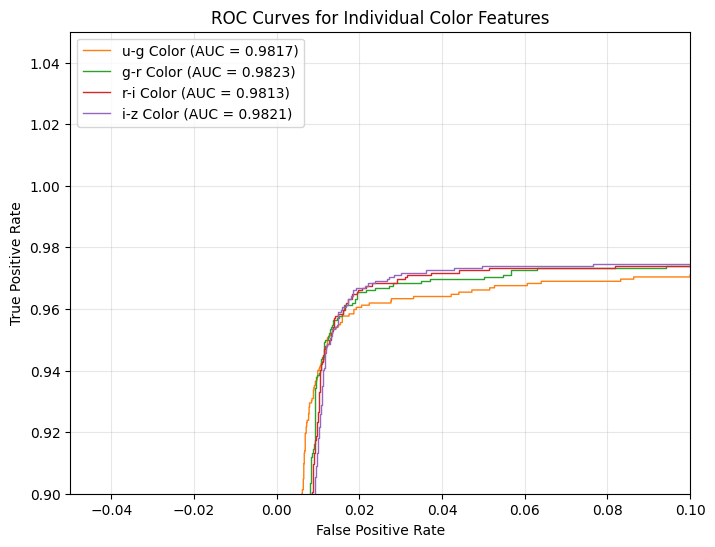

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA()
ROC_plot(qda)

### Gaussian Mixture Model (GMM)
We have already talk about GMM in the exercise 5. Here we use the GMM as a gneralization of the QDA, where we assume that each class is described by a gaussian pdf. Now we can assume that each class is described by a gassan mixture model, that is a weighted sum of gaussian pdfs:
$$
p(\vec{x}|C_k) = \sum_{j=1}^{M_k} \alpha_{jk} \mathcal{N}(\vec{x}| \vec{\mu}_{jk}, \Sigma_{jk})
$$  
where $M_k$ is the number of gaussian components for class $k$ and $\alpha_{jk}$ is the weight of the $j$-th component of class $k$. 

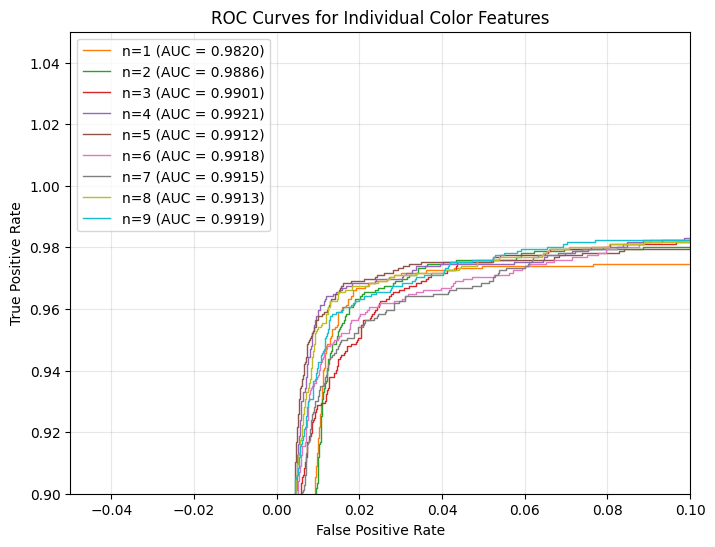

In [15]:
from astroML.classification import GMMBayes

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
for n in range(1, 10): # number of Gaussian components
    gmm = GMMBayes(n_components=n)
    gmm.fit(X_train[:, 0:4], y_train)
    y_pred = gmm.predict_proba(X_test[:, 0:4])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'n={n} (AUC = {roc_auc:.4f})')

plt.xlim([-0.05, 0.1])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Color Features')
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.show()

We can see how with just one component per class we obtain, as expected, the same result of QDA.

### K-Nearest Neighbors (KNN)
The idea behind KNN is that if two points, $x, x'$ are very close in the feature space, it is probable that they belong to the same class. 
$$
\text{if } ||x - x'||\rightarrow 0\, \Rightarrow\, p(C_k|x) \approx p(C_k|x')
$$
So we can classify a new point by looking at the $K$ nearest neighbors in the training set and assigning the class that is most frequent among them. 

Acting on the attbute `metric` we can choose the distance metric to use, the Minkowski metric is the default one, while modifying the attribute `weights` we can choose if to use uniform weights (all neighbors have the same weight) or distance weights (the weight of a neighbor is inversely proportional to its distance from the point to classify). By default the algorithm uses uniform weights.

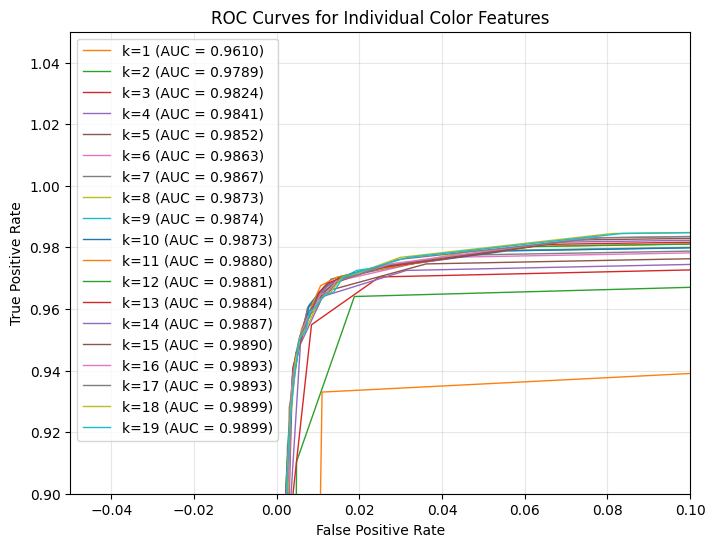

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scores = []

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
for n in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train[:, 0:4], y_train)
    y_pred = knn.predict_proba(X_test[:, 0:4])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'k={n} (AUC = {roc_auc:.4f})')

    scores.append(accuracy_score(y_test, y_pred > 0.5)) 

plt.xlim([-0.05, 0.1])
plt.ylim([0.9, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Individual Color Features')
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.show()

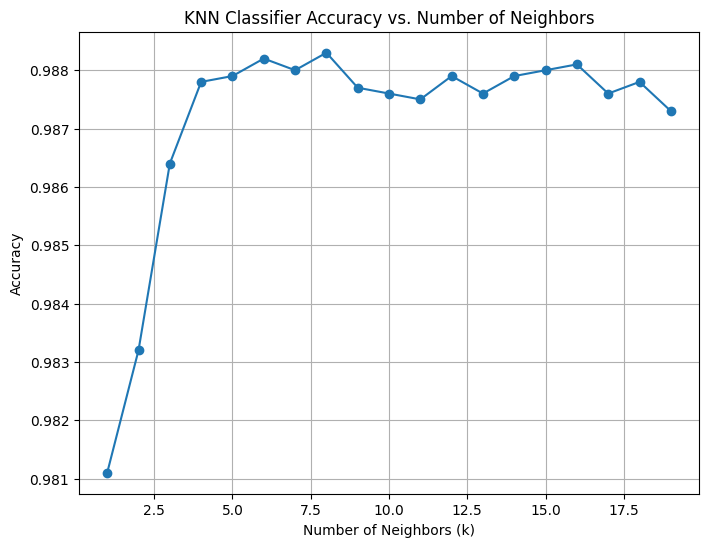

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

The best result is achived with $k = 8$.